In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
import torch
from torch.utils.data import DataLoader, Dataset

In [4]:
from google.colab import files
uploaded = files.upload()

Saving MyData.csv to MyData.csv


In [5]:
import pandas as pd
data = pd.read_csv('MyData.csv')  # Replace with the exact filename if different
print(data.head())

        id                                       comment_text  funny  wow  \
0  1083994  He got his money... now he lies in wait till a...      0    0   
1   650904  Mad dog will surely put the liberals in mental...      0    0   
2  5902188  And Trump continues his lifelong cowardice by ...      1    0   
3  7084460  "while arresting a man for resisting arrest".\...      0    0   
4  5410943     Tucker and Paul are both total bad ass mofo's.      0    0   

   sad  likes  disagree  toxicity  severe_toxicity   obscene  ...  white  \
0    0      2         0  0.373134         0.044776  0.089552  ...    NaN   
1    1      2         0  0.605263         0.013158  0.065789  ...    NaN   
2    2      3         7  0.666667         0.015873  0.031746  ...    NaN   
3    0      0         0  0.815789         0.065789  0.552632  ...    NaN   
4    0      1         0  0.550000         0.037500  0.337500  ...    NaN   

   asian  latino  other_race_or_ethnicity  physical_disability  \
0    NaN     N

In [6]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

# Load the SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and fast

# Generate embeddings for the text column
data['text_embeddings'] = list(model.encode(data['comment_text'], show_progress_bar=True))

# Convert embeddings into a DataFrame
embeddings = np.array(data['text_embeddings'].tolist())
embeddings_df = pd.DataFrame(embeddings, columns=[f'emb_{i}' for i in range(embeddings.shape[1])])

# Combine embeddings with numerical features
numerical_features = data[['funny', 'wow', 'sad', 'likes', 'disagree']]
X = pd.concat([embeddings_df, numerical_features], axis=1)
y = data['toxicity']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
import lightgbm as lgb
print(lgb.__version__)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


4.5.0


In [9]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val)

# Define parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}

# Train the model with early stopping using callbacks
lgbm_model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],                     # Validation set
    num_boost_round=1000,                        # Max boosting rounds
    callbacks=[lgb.early_stopping(stopping_rounds=50)]  # Early stopping callback
)

# Make predictions
y_pred = lgbm_model.predict(X_val)

# Convert y_val to binary (0 or 1) using threshold
y_val_binary = (y_val >= 0.5).astype(int)

roc_score = roc_auc_score(y_val_binary, y_pred)
print(f"AUC Score: {roc_score}")



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[614]	valid_0's auc: 0.906883
AUC Score: 0.8667090980513055


In [10]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Ensure y_test is binary for metrics
y_test_binary = (y_test >= 0.5).astype(int)

# Predict probabilities on the test set
y_pred_prob = lgbm_model.predict(X_test)

# Convert probabilities to binary predictions using a threshold
y_pred = (y_pred_prob >= 0.5).astype(int)

# Evaluate metrics
print("Accuracy:", accuracy_score(y_test_binary, y_pred))
print("ROC-AUC:", roc_auc_score(y_test_binary, y_pred_prob))  # Binary y_test for AUC
print("Classification Report:\n", classification_report(y_test_binary, y_pred))


Accuracy: 0.76725
ROC-AUC: 0.8667090980513055
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.70      0.79      2423
           1       0.65      0.87      0.75      1577

    accuracy                           0.77      4000
   macro avg       0.77      0.78      0.77      4000
weighted avg       0.80      0.77      0.77      4000



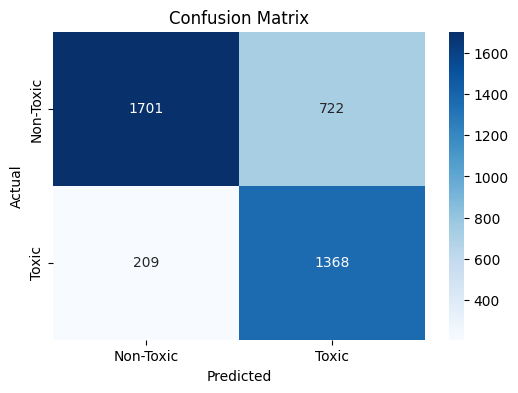

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Toxic", "Toxic"], yticklabels=["Non-Toxic", "Toxic"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

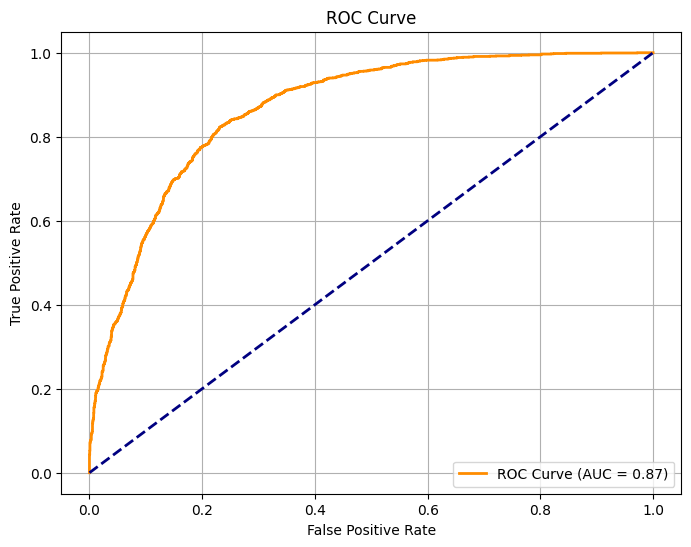

In [12]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


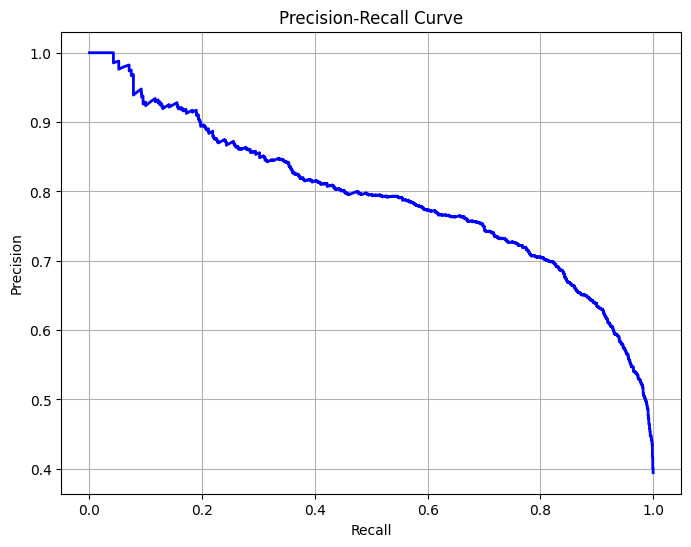

In [13]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, lw=2, color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()


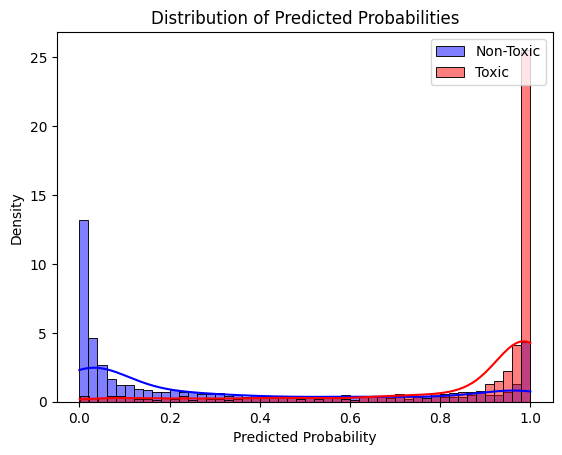

In [14]:
sns.histplot(y_pred_prob[y_test_binary == 0], bins=50, color='blue', kde=True, label='Non-Toxic', stat='density')
sns.histplot(y_pred_prob[y_test_binary == 1], bins=50, color='red', kde=True, label='Toxic', stat='density')
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend(loc="upper right")
plt.show()

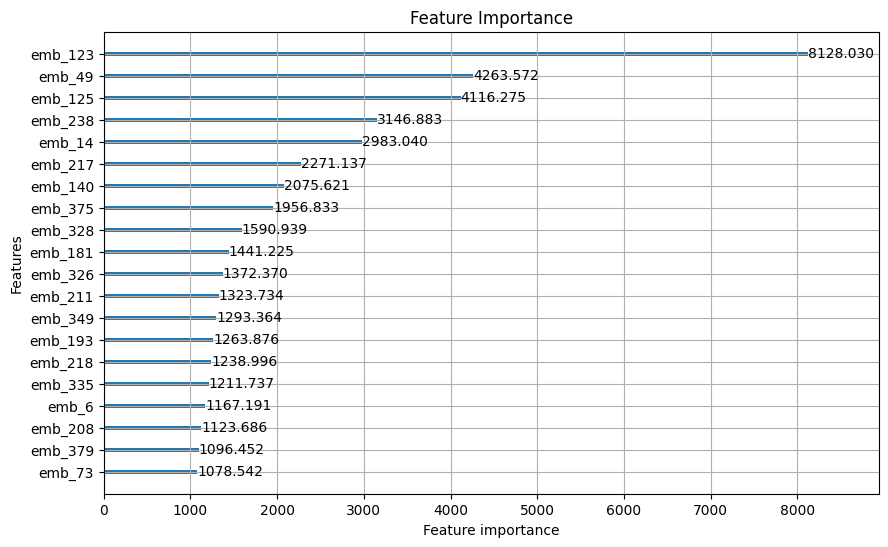

In [15]:
# Plot feature importance
lgb.plot_importance(lgbm_model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance")
plt.show()
